*This is for simulating correlation data using Monte Carlo.*

First, we make random choice to decide which light source is used.

'\nsingle photon source -> event 0\nthermal source -> event 1\nnothing detected -> event 2\n'

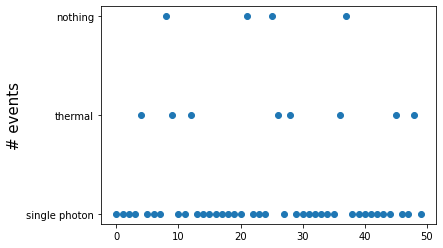

In [198]:
# determine which the light source for each detection

Ndetection = 50    # number of detections
psps = 0.70         #  probability of detecting a single photon source
pthermal = 0.2      # probability of detecting a thermal light source
pnon = 0.1          # probability of getting nothing / 2nd photon is not in the range of abs time range
source = tf.random.categorical(tf.math.log([[psps,pthermal,pnon]]), Ndetection)
plt.scatter(np.arange(Ndetection),source[0])
plt.ylabel('# events',fontsize=15)
plt.yticks([0,1,2],['single photon','thermal','nothing'])
'''
single photon source -> event 0
thermal source -> event 1
nothing detected -> event 2
'''


In [113]:
a = tf.math.log([[5.,1,1]])
a

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.609438, 0.      , 0.      ]], dtype=float32)>

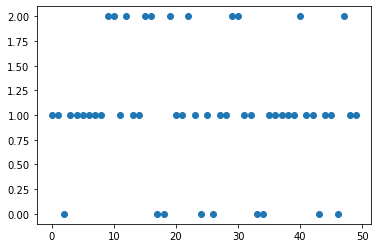

In [176]:
# samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
samples = tf.random.categorical([[pthermal,psps,pnon]], 50)
plt.scatter(np.arange(50),samples[0])

In [129]:
samples.numpy()

array([[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0]])